In [1]:
#gather assess clean analyze model visualize
#https://www.kaggle.com/airbnb/boston
import pandas as pd
import numpy as np
import seaborn as sns
import re
from re import sub

import statistics
from string import punctuation

import plotly.graph_objs as go

In [104]:
exec(open("./randomforestfunctions.py").read())

In [3]:
exec(open("./fancy_string.py").read())

In [89]:
def to_money(val):
    '''
    INPUT:
    str formatted $1,000.00 indicating monetary value 
    
    OUTPUT:
    float of monetary value
    '''
    val = val[1:len(val)-3]
    val = val.replace(',', '')
    return(float(val))

def col_to_money(colname, df):
    return ([to_money(i) if isinstance(i, float) == False else None for i in df[colname]])

def col_from_percent(colname, df):
    return([float(i.replace('%', ''))if isinstance(i, float) == False else None for i in df[colname]])
    
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1),dums], axis=1)
        except:
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        for n in i:
            if n not in column_names:
                column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def text_to_cols(colname, df):
    '''
    INPUT:
    str column name and dataframe that contains it 
    
    OUTPUT:
    dataframe with new columns containing str properties, original str column removed
    '''
    fancy_strings = [FancyString(i) for i in df[colname]]
    df[colname + '_adcount'] = [i.ad_count() for i in fancy_strings]
    df[colname + '_wordcount'] = [i.wordcount() for i in fancy_strings]
    df = df.drop(colname, axis = 1)
    return(df)

**GATHER**

In [92]:
#collecting relevant dataframes
listings = pd.read_csv('./listings.csv', index_col = 0).reset_index()
reviews = pd.read_csv('./reviews.csv', index_col = 0).reset_index()
full_df = reviews.merge(listings, left_on = 'listing_id', right_on = 'id', how = 'inner')

**ASSESS**

* there is consistent missingness that will have to be addressed
* there are many objects requiring examination
* it's multilevel, so may want to aggreggate
* there are many instances of variable clusters (around review_score etc) where it is likely that vars are highly correlated

In [93]:
print(full_df.shape)
print("\n")
print(full_df.info())
print("\n")
full_df.describe()

(68275, 101)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68275 entries, 0 to 68274
Columns: 101 entries, listing_id to reviews_per_month
dtypes: float64(18), int64(18), object(65)
memory usage: 53.1+ MB
None




,listing_id,id_x,reviewer_id,id_y,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,68275.000000,68275.000000,0.0,68275.000000,...,68197.000000,68202.000000,68200.000000,68202.000000,68197.000000,68199.000000,0.0,0.0,68275.000000,68275.000000
mean,4.759910e+06,5.246516e+07,2.802389e+07,4.759910e+06,2.016091e+13,1.444614e+07,13.972830,13.972830,NaN,42.338246,...,9.474684,9.316868,9.705777,9.703953,9.361145,9.234564,NaN,NaN,5.141721,3.669015
std,3.788990e+06,2.790991e+07,2.234097e+07,3.788990e+06,6.585986e+00,1.635912e+07,66.806719,66.806719,NaN,0.026307,...,0.655534,0.834400,0.521058,0.514301,0.721928,0.649583,NaN,NaN,10.991914,2.492277
min,3.353000e+03,1.021000e+03,1.430000e+02,3.353000e+03,2.016091e+13,4.240000e+03,1.000000,1.000000,NaN,42.235942,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,1.458081e+06,3.010420e+07,9.001346e+06,1.458081e+06,2.016091e+13,2.005394e+06,1.000000,1.000000,NaN,42.318251,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,1.710000
50%,4.080000e+06,5.223121e+07,2.305179e+07,4.080000e+06,2.016091e+13,8.157833e+06,2.000000,2.000000,NaN,42.343722,...,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,NaN,2.000000,3.220000
75%,7.377034e+06,7.663248e+07,4.213454e+07,7.377034e+06,2.016091e+13,2.185136e+07,6.000000,6.000000,NaN,42.357792,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,5.000000,5.330000
max,1.484378e+07,9.999045e+07,9.335034e+07,1.484378e+07,2.016091e+13,9.287818e+07,749.000000,749.000000,NaN,42.389982,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


**CLEAN**
* eliminate any completely empty rows or columns
* reformat objects that should be numbers 
* for amenities in particular, have to transform json-like bracket into list
* for text vars convert to word count and adjective count
* sift through and remove variables that won't be meaningful (such as city (they are all in boston)), or are redundant
* convert objects to dummy var dataframes
* concatenate and aggregate on listing id

In [94]:
#clean
#eliminate any fully empty rows or columns and retain an item-level index
full_df = full_df.dropna(axis = 0, how = 'all')
full_df = full_df.dropna(axis = 1, how = 'all')

In [95]:
#reformatting data types that should be floats but are currently obj

money_col_list = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for i in money_col_list:
    full_df[i + '_float'] = col_to_money(i, full_df)
    
percent_col_list = ['host_response_rate', 'host_acceptance_rate']
for i in percent_col_list:
    full_df[i] = col_from_percent(i, full_df)

In [96]:
#reformatting amenities:  in original dataframe, strings not in "" are options, while strings in "" are offered.
#for our purposes, retain only the offered options 

full_df['amenities'] = [re.findall('"([^"]*)"', i) if isinstance(i, float) == False else None for i in full_df['amenities']]
amenities = list_to_cols(full_df['amenities'])

amenities =create_dummy_df(amenities,list(amenities.columns), True)
#this looks like an error/missing data so these vals were dropped
amenities = amenities[amenities.columns.drop(list(amenities.filter(regex='translation missing')))]

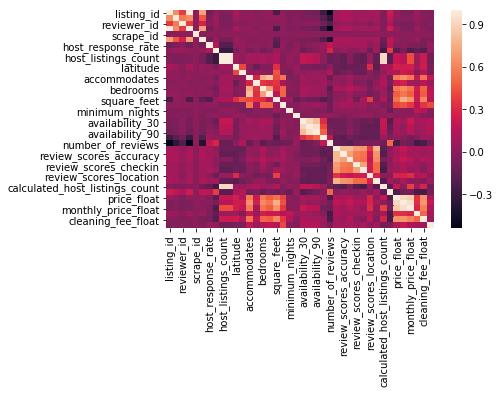

In [97]:
num_df = full_df.select_dtypes(include=['float64', 'int64']).copy().reset_index(drop = True)
sns.heatmap(num_df.corr(), annot=False, fmt=".2f");

In [10]:
#clean
text_cols = ['comments', 'name', 'summary', 'space', 'description','house_rules']
txt_df = full_df[text_cols].copy()

for i in text_cols:
    txt_df = text_to_cols(i, txt_df)

In [12]:
txt_df.to_csv('./txt_df.csv')

In [41]:
txt_df = txt_df.drop(txt_df.columns[0], axis=1)

In [98]:
bad_objs = "calendar_updated price extra_people smart_location cleaning_fee security_deposit amenities first_review last_review city zipcode weekly_price neighbourhood_cleansed host_since monthly_price calendar_last_scraped date reviewer_name listing_url neighborhood_overview last_scraped experiences_offered notes transit access interaction thumbnail_url medium_url picture_url xl_picture_url host_url host_name host_location host_about host_thumbnail_url host_picture_url host_neighbourhood host_verifications host_has_profile_pic street neighbourhood"
bad_objL = bad_objs.split()

obj_df = full_df.select_dtypes(include=['object']).copy()
obj_df = obj_df.drop(text_cols, axis = 1)
obj_df = obj_df.drop(bad_objL, axis = 1)

In [99]:
obj_df =create_dummy_df(obj_df,list(obj_df.columns), True)
obj_df = obj_df.reset_index(drop = True)

obj_df2 = pd.concat([obj_df, amenities], axis = 1)

obj_df2 = obj_df2[obj_df2.columns.drop(list(obj_df2.filter(regex='index')))]


In [100]:
clean_df = pd.concat([num_df, obj_df], axis = 1)
clean_df = clean_df[clean_df.columns.drop(list(clean_df.filter(regex='id')))]

clean_df['listing_id'] = full_df['listing_id']
clean_df = pd.concat([clean_df, txt_df], axis = 1)
clean_df = clean_df.loc[:, (clean_df != 0).any(axis=0)]

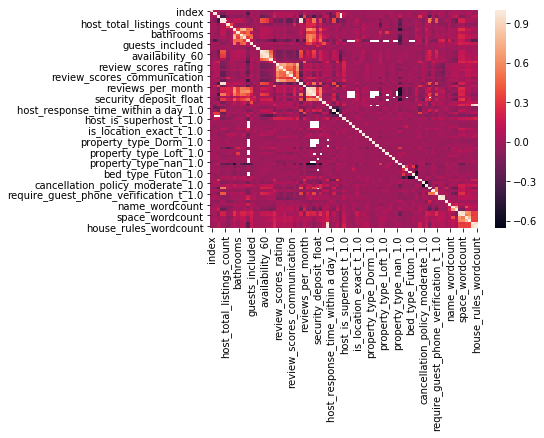

In [101]:
sns.heatmap(clean_agg.corr(), annot=False, fmt=".2f");

In [102]:
clean_agg = clean_df.groupby('listing_id').agg('mean').reset_index(drop = True)

In [105]:
X, y = prep_for_rf('review_scores_rating',clean_agg,  'review_scores')

In [106]:
best_param = specify_best(model = RandomForestRegressor(random_state = 15), typ = 'RF', X = X, y = y)

rf = RandomForestRegressor(min_samples_split=best_param.get('min_samples_split'), 
                           max_features= best_param.get('max_features'),random_state = 15)

{'max_features': 12, 'min_samples_split': 12}


In [119]:
rf_res = run_modelskfold(rf, X, y, pi_bool = True)

results = ext_featEPRF(rf_res[2], mean = True)
print_vals(best_param, rf_res, results)

mss: 12
max_feat: 12
mean_mae: 5.598513118553469
mean_mse: 72.48346197494297

frequency: 

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10

feat_imp: 

0.005361331539846411
0.005391141118973419
0.005513889714934046
0.006001543165296624
0.006947719159682388
0.007226501094090267
0.007283843682442918
0.008946428877804146
0.010064847306306728
0.01112720532324135
0.011834590668673341
0.012032779143134355
0.013816508208669231
0.016252842598967473
0.02194845319251677
0.03062542565735326
0.03941425742604626
0.05601076633876363

top_ features

availability_90
availability_60
availability_365
latitude
number_of_reviews
availability_30
house_rules_wordcount
comments_adcount
description_wordcount
cleaning_fee_float
host_response_rate
longitude
host_listings_count
calculated_host_listings_count
host_total_listings_count
price_float
comments_wordcount
host_is_superhost_t


In [120]:

fig = go.Figure()

fig.add_trace(go.Bar(x=results['features'], y = results['feat_imps'], name = 'Ratings_Score_Top_Pred'))